In [39]:
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from snowflake.ml.registry import Registry
from snowflake.snowpark import Session
from snowflake.snowpark.context import get_active_session
from xgboost import XGBClassifier

from common import get_next_model_version

try:
    session = get_active_session()
except:
    session = Session.builder.create()

DB = 'DEMO'
SCHEMA = 'PUBLIC'
COMPUTE_WAREHOUSE = 'DEMO_WH'
model_name = 'MORTGAGE_LENDING_MLOPS'

In [18]:
try:
    print("Reading table data...")
    df = session.table(f"{DB}.{SCHEMA}.MORTGAGE_LENDING_DEMO_DATA").to_pandas()
    print(df.head(5))
except:
    print("Table not found! Uploading data to snowflake table")
    df_pandas = pd.read_csv("MORTGAGE_LENDING_DEMO_DATA.csv.zip")
    session.write_pandas(df_pandas, "MORTGAGE_LENDING_DEMO_DATA", auto_create_table=True)
    df = session.table(f"{DB}.{SCHEMA}.MORTGAGE_LENDING_DEMO_DATA").to_pandas()
    print(df.head(5))

Reading table data...
   LOAN_ID                       TS LOAN_TYPE_NAME LOAN_PURPOSE_NAME  \
0   460124  2024-05-24 07:20:38.400  VA-guaranteed     Home purchase   
1   444931  2024-09-11 20:43:52.320    FHA-insured     Home purchase   
2   456257  2024-03-13 20:36:23.040    FHA-insured     Home purchase   
3   313469  2024-06-30 10:03:47.520   Conventional     Home purchase   
4   266947  2024-07-29 14:08:26.880   Conventional       Refinancing   

   APPLICANT_INCOME_000S  LOAN_AMOUNT_000S       COUNTY_NAME  MORTGAGERESPONSE  
0                    NaN               196  Jefferson County                 1  
1                   22.0                65       Erie County                 1  
2                    NaN               147       Erie County                 1  
3                   44.0                90     Oswego County                 1  
4                    NaN               271     Orange County                 1  


In [19]:
def clean_and_engineer_features(df, county_income_map=None):
    """
    Clean data and perform feature engineering for mortgage lending model.
    Works for both batch training and real-time inference.
    
    Args:
        df: pandas DataFrame with columns: LOAN_ID, TS, LOAN_TYPE_NAME, LOAN_PURPOSE_NAME,
            APPLICANT_INCOME_000S, LOAN_AMOUNT_000S, COUNTY_NAME, MORTGAGERESPONSE
        county_income_map: dict mapping COUNTY_NAME to mean income (for real-time inference)
                          If None, will compute from df (for training)
    
    Returns:
        tuple: (cleaned DataFrame, county_income_map dict)
    """
    df['TS'] = pd.to_datetime(df['TS'])
    
    current_time = datetime.now()
    df_max_time = df['TS'].max()
    
    timedelta_days_adjusted = (current_time - df_max_time).days - 1
    
    df['TIMESTAMP'] = df['TS'] + pd.Timedelta(days=timedelta_days_adjusted)
    
    median_income = df['APPLICANT_INCOME_000S'].median()
    
    df['MONTH'] = df['TIMESTAMP'].dt.month
    df['DAY_OF_YEAR'] = df['TIMESTAMP'].dt.dayofyear
    df['DOTW'] = df['TIMESTAMP'].dt.dayofweek
    
    df['MISSING_INCOME'] = df['APPLICANT_INCOME_000S'].isnull().astype(int)
    df['LOAN_AMOUNT'] = df['LOAN_AMOUNT_000S'] * 1000
    df['INCOME'] = df['APPLICANT_INCOME_000S'].fillna(median_income) * 1000
    df['INCOME_LOAN_RATIO'] = df['INCOME'] / df['LOAN_AMOUNT']
    
    if county_income_map is None:
        df['MEAN_COUNTY_INCOME'] = df.groupby("COUNTY_NAME")["INCOME"].transform('mean')
        county_income_map = df.groupby("COUNTY_NAME")["INCOME"].mean().to_dict()
    else:
        df['MEAN_COUNTY_INCOME'] = df['COUNTY_NAME'].map(county_income_map)
        overall_mean = df['INCOME'].mean()
        df['MEAN_COUNTY_INCOME'] = df['MEAN_COUNTY_INCOME'].fillna(overall_mean)
    
    df['HIGH_INCOME_FLAG'] = np.where(
        df['MISSING_INCOME'] == 1,
        0,
        (df['INCOME'] > df['MEAN_COUNTY_INCOME']).astype(int)
    )
    
    df = df.drop(columns=['TS', 'COUNTY_NAME','APPLICANT_INCOME_000S'])
    
    df = pd.get_dummies(df, columns=['LOAN_TYPE_NAME', 'LOAN_PURPOSE_NAME'], drop_first=False, dtype=int)
    df.columns = [re.sub(r'[^a-zA-Z0-9]+', '_', col.upper()) for col in df.columns]
    
    return df, county_income_map

print(f"Original shape: {df.shape}")

df_clean, county_stats = clean_and_engineer_features(df)

print(f"Cleaned shape: {df_clean.shape}")
print(f"\nMin TIMESTAMP: {df_clean['TIMESTAMP'].min()}")
print(f"Max TIMESTAMP: {df_clean['TIMESTAMP'].max()}")
print(f"\nCounty statistics computed for {len(county_stats)} counties")
print(f"\nFeatures created: {list(df_clean.columns)}")
df.head()

Original shape: (1107735, 8)
Cleaned shape: (1107735, 20)

Min TIMESTAMP: 2025-01-04 00:00:00
Max TIMESTAMP: 2025-12-02 07:40:13.440000

County statistics computed for 63 counties

Features created: ['LOAN_ID', 'LOAN_AMOUNT_000S', 'MORTGAGERESPONSE', 'TIMESTAMP', 'MONTH', 'DAY_OF_YEAR', 'DOTW', 'MISSING_INCOME', 'LOAN_AMOUNT', 'INCOME', 'INCOME_LOAN_RATIO', 'MEAN_COUNTY_INCOME', 'HIGH_INCOME_FLAG', 'LOAN_TYPE_NAME_CONVENTIONAL', 'LOAN_TYPE_NAME_FHA_INSURED', 'LOAN_TYPE_NAME_FSA_RHS_GUARANTEED', 'LOAN_TYPE_NAME_VA_GUARANTEED', 'LOAN_PURPOSE_NAME_HOME_IMPROVEMENT', 'LOAN_PURPOSE_NAME_HOME_PURCHASE', 'LOAN_PURPOSE_NAME_REFINANCING']


,LOAN_ID,TS,LOAN_TYPE_NAME,LOAN_PURPOSE_NAME,APPLICANT_INCOME_000S,LOAN_AMOUNT_000S,COUNTY_NAME,MORTGAGERESPONSE,TIMESTAMP,MONTH,DAY_OF_YEAR,DOTW,MISSING_INCOME,LOAN_AMOUNT,INCOME,INCOME_LOAN_RATIO,MEAN_COUNTY_INCOME,HIGH_INCOME_FLAG
0,460124,2024-05-24 07:20:38.400,VA-guaranteed,Home purchase,NaN,196,Jefferson County,1,2025-05-28 07:20:38.400,5,148,2,1,196000,88000.0,0.448980,81839.215686,0
1,444931,2024-09-11 20:43:52.320,FHA-insured,Home purchase,22.0,65,Erie County,1,2025-09-15 20:43:52.320,9,258,0,0,65000,22000.0,0.338462,81930.629669,0
2,456257,2024-03-13 20:36:23.040,FHA-insured,Home purchase,NaN,147,Erie County,1,2025-03-17 20:36:23.040,3,76,0,1,147000,88000.0,0.598639,81930.629669,0
3,313469,2024-06-30 10:03:47.520,Conventional,Home purchase,44.0,90,Oswego County,1,2025-07-04 10:03:47.520,7,185,4,0,90000,44000.0,0.488889,70994.971716,0
4,266947,2024-07-29 14:08:26.880,Conventional,Refinancing,NaN,271,Orange County,1,2025-08-02 14:08:26.880,8,214,5,1,271000,88000.0,0.324723,106242.587601,0


In [20]:
X = df_clean.drop(['MORTGAGERESPONSE','LOAN_ID','TIMESTAMP'],axis=1)
y = df_clean.MORTGAGERESPONSE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Calculated scale_pos_weight: {scale_pos_weight:.3f}")

param_grid = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [1,2,3,4],
    "min_child_weight": [1, 6]
}


model = XGBClassifier(objective='binary:logistic', 
                      eval_metric='logloss',
                      scale_pos_weight=scale_pos_weight)

xgb_improved = GridSearchCV(estimator=model, 
                           param_grid=param_grid)

xgb_improved.fit(X_train, y_train)

Calculated scale_pos_weight: 0.275


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1], 'max_depth': [1, 2, ...], 'min_child_weight': [1, 6], 'n_estimators': [100]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


{'Accuracy': 0.6744319808515193, 'Precision': 0.781809956666928, 'Recall': 0.6744319808515193, 'F1 Score': 0.7023358492449462}
{'Accuracy': 0.6738755600759506, 'Precision': 0.7815036778924823, 'Recall': 0.6738755600759506, 'F1 Score': 0.7018400556705751}

ROC AUC Score: 0.7554

Confusion Matrix:


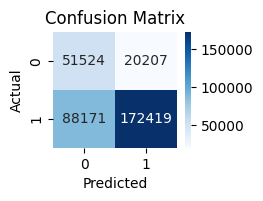

In [21]:
y_pred_improved = xgb_improved.predict(X_test)
y_pred_proba_improved = xgb_improved.predict_proba(X_test)[:, 1]

y_pred_train = xgb_improved.predict(X_train)
y_pred_proba_train = xgb_improved.predict_proba(X_train)[:, 1]

accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='weighted')
recall = recall_score(y_train, y_pred_train, average='weighted')
f1 = f1_score(y_train, y_pred_train, average='weighted')

metrics_train = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}

y_pred = xgb_improved.predict(X_test)
y_pred_proba = xgb_improved.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

metrics_test = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}
print(metrics_train)
print(metrics_test)

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
sample_data = X.sample(n=1)

reg = Registry(session=session, database_name= DB, schema_name= SCHEMA)
df = reg.show_models()
next_version = get_next_model_version(df, model_name)
print(next_version)

mortgage_model = reg.log_model(
    model_name=model_name,
    version_name = next_version,
    model=xgb_improved,
    sample_input_data= sample_data,
    metrics=metrics_test,
    target_platforms=["SNOWPARK_CONTAINER_SERVICES"]
)

V_11
Model logged successfully.: 100%|██████████| 6/6 [00:10<00:00,  1.81s/it]                          


In [23]:
#Here we see the BASE version is our default version
reg = Registry(session=session, database_name= DB, schema_name= SCHEMA)
m = reg.get_model(model_name)
m.default

ModelVersion(
  name='MORTGAGE_LENDING_MLOPS',
  version='V_10',
)

In [24]:
recent_model_name = reg.get_model(model_name).last().version_name
m.default = recent_model_name
m.default

ModelVersion(
  name='MORTGAGE_LENDING_MLOPS',
  version='V_11',
)

In [25]:
# If you do not have a compute pool create one
session.sql(
'''CREATE COMPUTE POOL IF NOT EXISTS mortgage_inference
  MIN_NODES = 1
  MAX_NODES = 2
  INSTANCE_FAMILY = CPU_X64_S
  '''
).collect()

[Row(status='MORTGAGE_INFERENCE already exists, statement succeeded.')]

In [26]:
# If you do not have an image repo create on
session.sql(f'''
CREATE IMAGE REPOSITORY IF NOT EXISTS {DB}.{SCHEMA}.model_image_repo
''').collect()

[Row(status='MODEL_IMAGE_REPO already exists, statement succeeded.')]

In [12]:
cp_name = "mortgage_inference"
num_spcs_nodes = '2'
service_name = 'MORTGAGE_LENDING_PREDICTION_SERVICE'

extended_service_name = f'{DB}.{SCHEMA}.{service_name}'

In [68]:
mortgage_model.create_service(
    service_name=extended_service_name,
    service_compute_pool=cp_name,
    ingress_enabled=True,
    max_instances=int(num_spcs_nodes)
)

create_service logs saved to: /Users/cromano/Library/Logs/snowflake-ml/model_deploy_d65bf962_1764716229.log        
To see logs in console, set log level to INFO: logging.getLogger().setLevel(logging.INFO)                     
Model service created successfully: 100%|██████████| 6/6 [06:52<00:00, 68.75s/it]                             


'Inference service DEMO.PUBLIC.MORTGAGE_LENDING_PREDICTION_SERVICE with model DEMO.PUBLIC.MORTGAGE_LENDING_MLOPS version V_6 has been created. You can now call any of the following service functions to invoke the model: ["DEMO"."PUBLIC"."MORTGAGE_LENDING_PREDICTION_SERVICE"!PREDICT_PROBA, "DEMO"."PUBLIC"."MORTGAGE_LENDING_PREDICTION_SERVICE"!PREDICT]'

In [32]:
session.sql(
    f'''
    SHOW SERVICES LIKE '{service_name}'
    '''
).collect()

[Row(name='MORTGAGE_LENDING_PREDICTION_SERVICE', status='RUNNING', database_name='DEMO', schema_name='PUBLIC', owner='SYSADMIN', compute_pool='MORTGAGE_INFERENCE', dns_name='mortgage-lending-prediction-service.hvfr.svc.spcs.internal', current_instances=2, target_instances=2, min_ready_instances=2, min_instances=2, max_instances=2, auto_resume='true', external_access_integrations=None, created_on=datetime.datetime(2025, 12, 2, 15, 1, 58, 1000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), updated_on=datetime.datetime(2025, 12, 3, 6, 55, 50, 874000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), resumed_on=datetime.datetime(2025, 12, 3, 6, 55, 50, 874000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), suspended_on=datetime.datetime(2025, 12, 3, 6, 27, 32, 178000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), auto_suspend_secs=1800, comment=None, owner_role_type='ROLE', query_warehouse=None, is_job='false', 

In [14]:
session.sql(
    f'''
    ALTER SERVICE {service_name} resume;
    '''
).collect()

[Row(status='Statement executed successfully.')]

In [34]:
session.sql('show endpoints in service MORTGAGE_LENDING_PREDICTION_SERVICE').to_pandas()

,"""name""","""port""","""port_range""","""protocol""","""is_public""","""ingress_url"""
0,inference,5000,None,HTTP,true,bfc46pfe-sfsenorthamerica-cromano.snowflakecom...


In [35]:
mv_container = reg.get_model(model_name).default
results = mv_container.run(X_test, 
                 function_name = "predict_proba", 
                 service_name = "MORTGAGE_LENDING_PREDICTION_SERVICE").rename(columns={'output_feature_0': 'XGB_PREDICTION'})

results.head()

,XGB_PREDICTION,output_feature_1
0,0.201979,0.798021
1,0.733754,0.266246
2,0.348380,0.651620
3,0.785630,0.214370
4,0.375353,0.624647


#### If you are in an external IDE move to 3_Call_Endpoint.py and call from a terminal

In [36]:
payload = X_test.iloc[[1]].to_dict(orient='records')[0]
payload_list = [v for k,v in payload.items()]
datalist = [[0, *payload_list]]
payload = {"data":datalist}
payload

{'data': [[0,
   615,
   8,
   241,
   4,
   0,
   615000,
   114000.0,
   0.18536585365853658,
   149375.90308231063,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1]]}

In [38]:
# This is an internal service call and only works within Snowflake, uncomment out if inside a Snowflake Notebook

# headers = {
#     "Content-Type": "application/json"
# }

# def send_request(payload: dict):
#     output = requests.post('http://mortgage-lending-prediction-service.hvfr.svc.spcs.internal:5000/predict-proba', json=payload, headers=headers)
#     assert output.status_code == 200, f"Failed to get response from the service. Status code: {output.status_code}"
#     return output.content

# prediction = send_request(payload)
# decoded_string = prediction.decode('utf-8')
# data_dict = json.loads(decoded_string)
# prediction = data_dict['data'][0][1]['output_feature_0']
# prediction

In [40]:
# # This is an internal service call and only works within Snowflake, uncomment out if inside a Snowflake Notebook

# county_income_map = {"Albany County":95647.05145862026,"Allegany County":64386.00212089077,"Bronx County":97606.68467251858,"Broome County":76290.48843187661,"Cattaraugus County":72764.41102756892,"Cayuga County":77790.11099899092,"Chautauqua County":79235.60855263157,"Chemung County":73766.70766707667,"Chenango County":66042.23864836326,"Clinton County":78636.21708758731,"Columbia County":122745.42008843967,"Cortland County":77143.93226716839,"Delaware County":92202.97699594047,"Dutchess County":115418.6339313818,"Erie County":81930.62966915689,"Essex County":116667.98810703667,"Franklin County":77278.45528455285,"Fulton County":73541.28440366972,"Genesee County":68232.49097472924,"Greene County":113467.48554913295,"Hamilton County":131573.6040609137,"Herkimer County":72773.59583092068,"Jefferson County":81839.2156862745,"Kings County":149160.22550255916,"Lewis County":72904.59363957598,"Livingston County":79174.83756645009,"Madison County":81486.63926002056,"Monroe County":83657.39600113712,"Montgomery County":65169.91341991342,"Nassau County":149375.90308231063,"New York County":366531.1911137558,"Niagara County":73382.02475147089,"Oneida County":75246.8865701784,"Onondaga County":84442.59476357952,"Ontario County":93381.55291790307,"Orange County":106242.58760107816,"Orleans County":63666.015625,"Oswego County":70994.97171590195,"Otsego County":79904.01146131805,"Putnam County":128291.87604690118,"Queens County":105031.19104924217,"Rensselaer County":89414.3950263032,"Richmond County":106718.19370411345,"Rockland County":140828.1479068252,"Saratoga County":105582.34139960758,"Schenectady County":82226.26695217701,"Schoharie County":76151.17891816921,"Schuyler County":87856.89655172414,"Seneca County":77448.03695150116,"St. Lawrence County":72985.73200992556,"Steuben County":73743.1352102885,"Suffolk County":156381.5572681371,"Sullivan County":110201.3093289689,"Tioga County":72064.11323896753,"Tompkins County":102248.40764331211,"UNKNOWN":72155.6420233463,"Ulster County":108157.69944341373,"Warren County":101275.29411764706,"Washington County":75180.87182823682,"Wayne County":72683.10563145619,"Westchester County":180657.2609089993,"Wyoming County":69375.25562372188,"Yates County":90048.16223067173}

# def clean_and_engineer_features(df, county_income_map=county_income_map):
#     """
#     Clean data and perform feature engineering for mortgage lending model.
#     Works for both batch training and real-time inference.
    
#     Args:
#         df: pandas DataFrame with columns: LOAN_ID, TS, LOAN_TYPE_NAME, LOAN_PURPOSE_NAME,
#             APPLICANT_INCOME_000S, LOAN_AMOUNT_000S, COUNTY_NAME, MORTGAGERESPONSE
#         county_income_map: dict mapping COUNTY_NAME to mean income (for real-time inference)
#                           If None, will compute from df (for training)
    
#     Returns:
#         tuple: (cleaned DataFrame, county_income_map dict)
#     """
#     df['TS'] = pd.to_datetime(df['TS'])
    
#     current_time = datetime.now()
#     df_max_time = df['TS'].max()
    
#     timedelta_days_adjusted = (current_time - df_max_time).days - 1
    
#     df['TIMESTAMP'] = df['TS'] + pd.Timedelta(days=timedelta_days_adjusted)
    
#     median_income = df['APPLICANT_INCOME_000S'].median()
    
#     df['MONTH'] = df['TIMESTAMP'].dt.month
#     df['DAY_OF_YEAR'] = df['TIMESTAMP'].dt.dayofyear
#     df['DOTW'] = df['TIMESTAMP'].dt.dayofweek
    
#     df['MISSING_INCOME'] = df['APPLICANT_INCOME_000S'].isnull().astype(int)
#     df['LOAN_AMOUNT'] = df['LOAN_AMOUNT_000S'] * 1000
#     df['INCOME'] = df['APPLICANT_INCOME_000S'].fillna(median_income) * 1000
#     df['INCOME_LOAN_RATIO'] = df['INCOME'] / df['LOAN_AMOUNT']
    
#     df['MEAN_COUNTY_INCOME'] = df['COUNTY_NAME'].map(county_income_map)
#     overall_mean = df['INCOME'].mean()
#     df['MEAN_COUNTY_INCOME'] = df['MEAN_COUNTY_INCOME'].fillna(overall_mean)
    
#     df['HIGH_INCOME_FLAG'] = np.where(
#         df['MISSING_INCOME'] == 1,
#         0,
#         (df['INCOME'] > df['MEAN_COUNTY_INCOME']).astype(int)
#     )
    
#     df = df.drop(columns=['TS', 'COUNTY_NAME','APPLICANT_INCOME_000S'])
    
#     df = pd.get_dummies(df, columns=['LOAN_TYPE_NAME', 'LOAN_PURPOSE_NAME'], drop_first=False, dtype=int)
#     df.columns = [re.sub(r'[^a-zA-Z0-9]+', '_', col.upper()) for col in df.columns]
    
#     return df
    
# INFERENCE_COLUMNS = [
#     'LOAN_AMOUNT_000S',
#     'MONTH',
#     'DAY_OF_YEAR',
#     'DOT',
#     'WMISSING_INCOME',
#     'LOAN_AMOUNT',
#     'INCOME',
#     'INCOME_LOAN_RATIO',
#     'MEAN_COUNTY_INCOME',
#     'HIGH_INCOME_FLAG',
#     'LOAN_TYPE_NAME_CONVENTIONAL',
#     'LOAN_TYPE_NAME_FHA_INSURED',
#     'LOAN_TYPE_NAME_FSA_RHS_GUARANTEED',
#     'LOAN_TYPE_NAME_VA_GUARANTEED',
#     'LOAN_PURPOSE_NAME_HOME_IMPROVEMENT',
#     'LOAN_PURPOSE_NAME_HOME_PURCHASE',
#     'LOAN_PURPOSE_NAME_REFINANCING'
# ]

# df_infer = pd.DataFrame(0, index=[0], columns=INFERENCE_COLUMNS)

# COUNTY_NAMES = list(county_income_map.keys())

# LOAN_TYPES = ["Conventional", "FHA-insured", "FSA/RHS-guaranteed", "VA-guaranteed"]
# LOAN_PURPOSES = ["Home purchase", "Refinancing", "Home improvement"]

# st.title("🏡 Loan Application Data Collector")
# st.markdown("Enter the loan application details below. All amounts are in thousands (000s).")

# # --- 2. Data Entry Form ---
# with st.form(key='loan_data_form'):
    
#     st.header("Loan Details")

#     loan_type = st.selectbox(
#         "Loan Type",
#         options=LOAN_TYPES,
#         index=0,
#         help="The type of loan being applied for."
#     )

#     loan_purpose = st.selectbox(
#         "Loan Purpose",
#         options=LOAN_PURPOSES,
#         index=0,
#         help="The reason for the loan (e.g., Home purchase, Refinancing)."
#     )

#     st.header("Financial Information (in 000s)")

#     income_input = st.text_input(
#         "Applicant Income (in 000s)",
#         placeholder="Enter income (e.g., 85.5 or leave blank)",
#         help="Applicant's gross income in thousands. Can be left blank."
#     )
    
#     loan_amount = st.number_input(
#         "Loan Amount (in 000s)",
#         min_value=1, 
#         step=1,
#         format="%d",
#         help="The total loan amount in thousands. Must be a positive integer.",
#     )

#     st.header("Location")

#     county_name = st.selectbox(
#         "County Name",
#         options=COUNTY_NAMES,
#         index=0
#     )
    
#     submit_button = st.form_submit_button(label='Submit Loan Data')

# if submit_button:
#     start_time = time.time()
#     errors = []
    
#     if county_name == "Select County":
#         errors.append("Please select a valid County Name.")
    
#     if loan_amount is None or loan_amount < 1:
#         errors.append("Loan Amount cannot be blank and must be 1 or greater.")

#     applicant_income = None
#     if income_input.strip():
#         try:
#             applicant_income = float(income_input.strip())
#         except ValueError:
#             errors.append("Applicant Income must be a number (e.g., 85 or 85.5).")
    
#     if errors:
#         for error in errors:
#             st.error(error)
#         st.warning("Please correct the errors and resubmit.")
#     else:
#         current_ts = datetime.now().isoformat()

#         data = {
#             "TS": [current_ts],
#             "LOAN_TYPE_NAME": [loan_type],
#             "LOAN_PURPOSE_NAME": [loan_purpose],
#             "APPLICANT_INCOME_000S": [applicant_income if applicant_income is not None else np.nan], 
#             "LOAN_AMOUNT_000S": [int(loan_amount)],
#             "COUNTY_NAME": [county_name]
#         }
        
#         df = pd.DataFrame(data)
#         df_clean = clean_and_engineer_features(df)

#         missing_cols = list(set(df_infer.columns) - set(df_clean.columns))
#         for col in missing_cols:
#             df_clean[col] = 0
#         df_clean = df_clean.reindex(columns=df_infer.columns, fill_value=0)
#         payload = df_clean.iloc[[0]].to_dict(orient='records')[0]
#         payload_list = [v for k,v in payload.items()]
#         datalist = [[0, *payload_list]]
#         payload = {"data":datalist}
        
#         import json
#         headers = {
#             "Content-Type": "application/json"
#         }
        
#         def send_request(payload: dict):
#             output = requests.post('http://mortgage-lending-prediction-service.hvfr.svc.spcs.internal:5000/predict-proba', json=payload, headers=headers)
#             assert output.status_code == 200, f"Failed to get response from the service. Status code: {output.status_code}"
#             return output.content
        
#         prediction = send_request(payload)
#         decoded_string = prediction.decode('utf-8')
#         data_dict = json.loads(decoded_string)
#         prediction = data_dict['data'][0][1]['output_feature_0']
#         end_time = time.time()
#         runtime = end_time - start_time
#         st.success("Probability of getting accepted")
        
#         # Display the resulting DataFrame
#         st.write(prediction)
#         st.write(f"Prediction service runtime: {runtime:.3f} seconds")
